In [1]:
import numpy as np
from astropy.io import fits
from MyTool import Maps
from scipy import ndimage
import proplot as pplt

In [7]:
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import units as u
cosmos = FlatLambdaCDM(H0=70, Om0=0.308)
dA = cosmos.angular_diameter_distance(z=0.05547)
theta = 25
theta_radian = theta * np.pi / 180 / 3600

# arc length = radius * angle
distance_Mpc = dA * theta_radian

print(distance_Mpc) # 3.3846475 Mpc

0.026927093406824757 Mpc


In [3]:
hdu = fits.open("/Users/txl/Desktop/MaNGA/Data/drpall-v3_1_1.fits")
data = hdu[1].data
GALS = data['plateifu']
print(len(GALS))

11273


In [ ]:
# Read the need-checked files
import os
folder = '/Users/txl/Desktop/MaNGA/Pairs'
test_gal = [os.path.splitext(f)[0] for f in os.listdir(folder) if f.endswith('.png')]
print(len(test_gal))

In [11]:
reju_pre = []
not_reju = []
gal_no_data = []
i = 0

Total 94 galaxies!


/Users/txl/Desktop/MaNGA/Codes/MyTool.py:133: RuntimeWarning: divide by zero encountered in divide
  hd_err, dn_err = 1/np.sqrt(hd_ivar), 1/np.sqrt(dn_ivar)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:184: RuntimeWarning: divide by zero encountered in divide
  err  = 1/np.sqrt(ivar)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:324: RuntimeWarning: divide by zero encountered in log10
  y, x = np.log10(o3_spa/hb_spa), np.log10(n2_spa/ha_spa)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:324: RuntimeWarning: invalid value encountered in log10
  y, x = np.log10(o3_spa/hb_spa), np.log10(n2_spa/ha_spa)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:335: RuntimeWarning: divide by zero encountered in divide
  HaEW_err  = 1/np.sqrt(HaEW_ivar)
/var/folders/8q/svw_20t17nz2mj7zww86s_xh0000gn/T/ipykernel_46809/296445509.py:14: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labelled_array, num

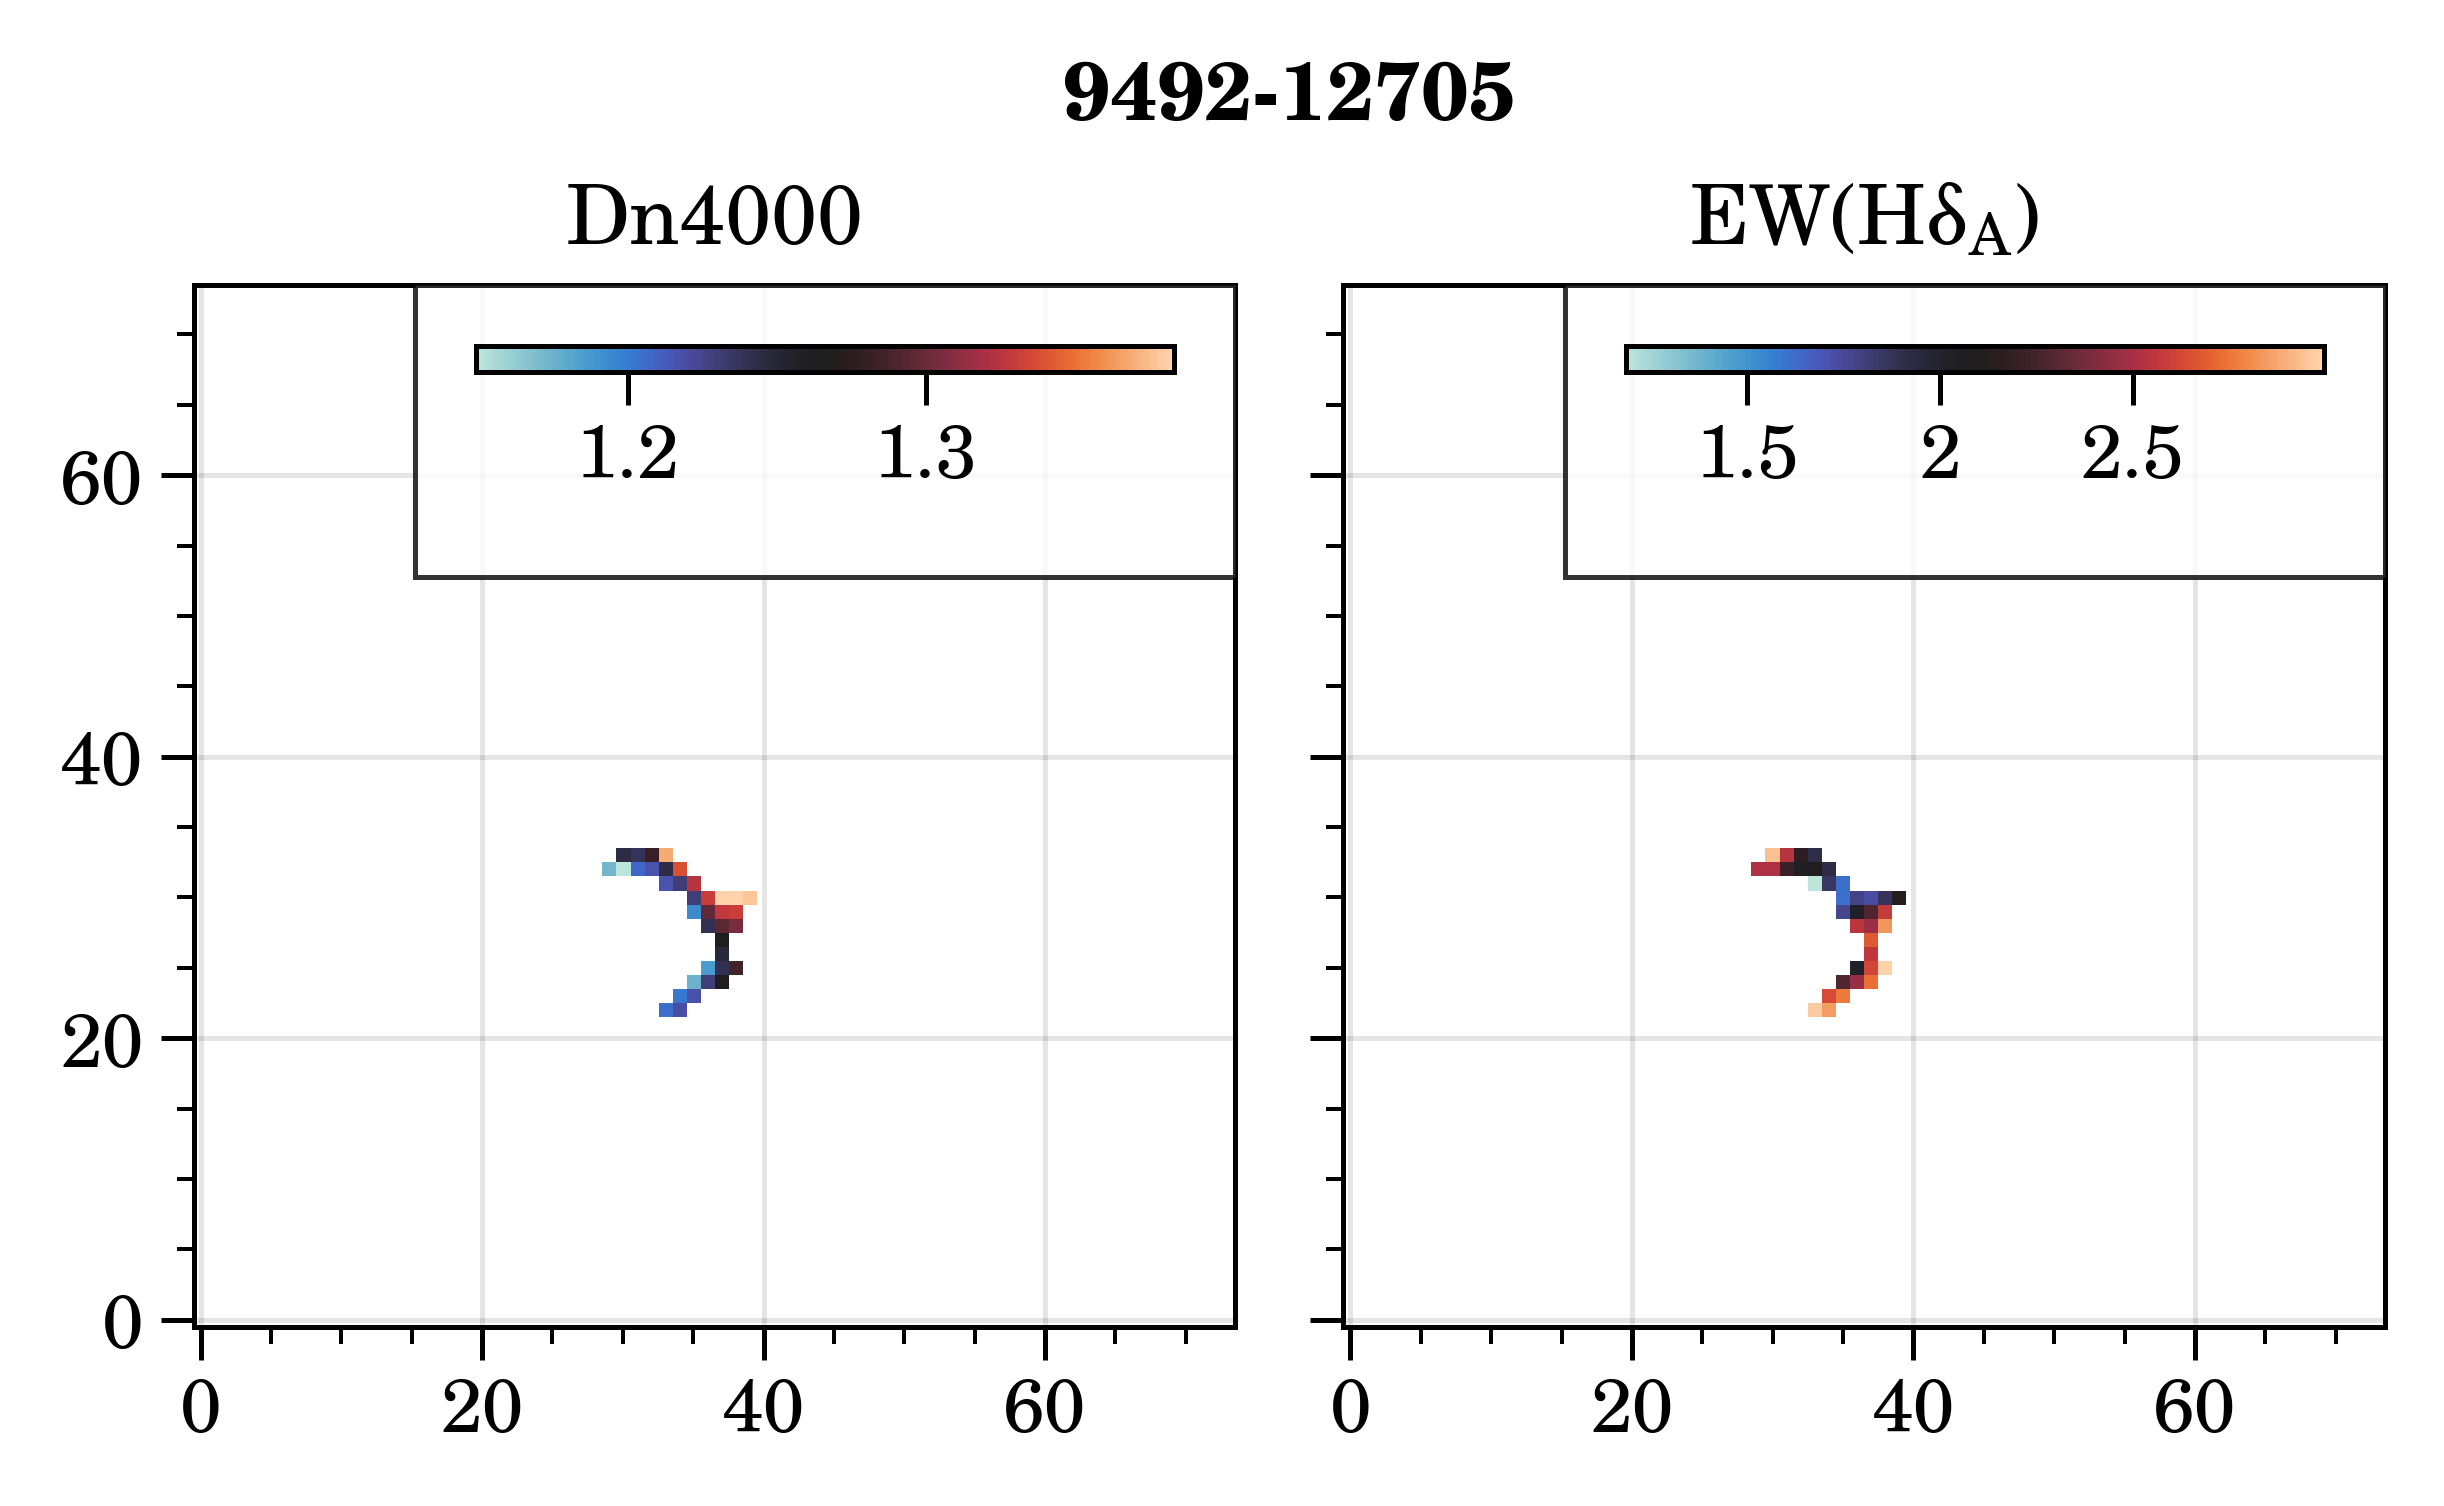

In [16]:
gal_2nd = np.loadtxt('/Users/txl/Desktop/spa_gal_v2.txt', dtype='str')
print('Total %i galaxies!' %len(gal_2nd))
i = 0
from MyTool import Maps
for gal in ['9492-12705']:
    try:
        maps = Maps(gal)

        # Needed mask
        hd, dn, mask_rej = maps.rejuvenated() # Rejuvenating mask, more than 10 connected spaxels will be selected
        mask_sf  = maps.BPT_sf_mask()[2] | maps.HaEW(lim=6)[1]  # Both SNR > 3
        hd, dn = np.ma.array(hd, mask=(mask_rej|mask_sf), fill_value=np.nan), np.ma.array(dn, mask=(mask_rej|mask_sf), fill_value=np.nan)

        labelled_array, num_feature = ndimage.measurements.label(~hd.mask)
        unique, counts = np.unique(labelled_array, return_counts = True)

        # Delete the non-target region spaxels
        counts, unique = np.delete(counts, 0), np.delete(unique, 0) # The empty in the maps
        #print(counts, unique)

        # Mask for region selection
        want_id = np.where(counts >= 10)[0]
        mask_num  = ~np.isin(labelled_array, unique[want_id])
        hd, dn = np.ma.array(hd, mask=mask_num, fill_value=np.nan), np.ma.array(dn, mask=mask_num, fill_value=np.nan)
        
        fig, ax = pplt.subplots(figsize=(4,3), ncols=2)
        im0 = ax[0].imshow(dn, cmap='Icefire', origin='lower')
        ax[0].colorbar(im0, loc='ur', width='0.3em', length=8)
        ax[0].title.set_text('Dn4000')
        im1 = ax[1].imshow(hd, cmap='Icefire', origin='lower')
        ax[1].colorbar(im1, loc='ur', width='0.3em', length=8)
        ax[1].title.set_text('EW(H$\delta_A$)')
        fig.format(suptitle='%s'%gal)
        #fig.savefig('/Volumes/KINGSTON/MaNGA/REJ_Distribution/Spectral_Plot/%s.png' %gal, dpi=200, transparent=True, facecolor='none')
        pplt.show()
        #pplt.close()
        '''
        if np.sum(len(want_id)) == 0:
            #print('%s has no any rejuvenating region!' %gal)
            not_reju.append(gal)
        else:
            print('==== %s has %d regions! ====' %(gal, len(want_id)))
            reju_pre.append(gal)
        '''
    except: gal_no_data.append(gal)

    i+=1
    if i%1000 == 0:
        print('Processed %d galaxies!' %i)
    


In [164]:
#good.remove('7443-9101')
print(len(reju_pre))

157


In [10]:
import pandas as pd 
df = pd.DataFrame(reju_pre)
df.to_csv("/Users/txl/Desktop/spa_reju_pre_0710.csv")

In [172]:
s = np.loadtxt('/Users/txl/Desktop/spa_gal_v2.txt', dtype=str)
print(len(s))

96


In [169]:
# To check the bits
def check_bits(gal):
    with fits.open('/Users/txl/Desktop/MaNGA/Data/drpall-v3_1_1.fits') as hdu:
        plateifu = hdu[1].data['plateifu']
        target_1 = hdu[1].data['MNGTARG1']
        target_3 = hdu[1].data['MNGTARG3']

    # Find galaxies
    if gal in plateifu:
        i = np.where(plateifu == gal)[0][0]
        bit_1 = [bit for bit in range(0, 15) if (target_1[i] & 1 << bit) > 0]
        bit_3 = [bit for bit in range(0, 28) if (target_3[i] & 1 << bit) > 0]
        print(f"Galaxy {gal} has bits in MNGTARG1: {bit_1}, MNGTARG3: {bit_3}")
        #return bit_1, bit_3
    else:
        print(f"Galaxy {gal} not found.")
        #return None, None
    # The criteria
    # (1) MNGTARG 1: Discard "RETIRED (14)" and "FILER (13)"
    # (2) MNGTARG 3: Choose "NONE" (0), means "Normal Galaxies"

In [170]:
for gal in s:
    check_bits(gal)

Galaxy 11751-12705 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy 9492-12704 has bits in MNGTARG1: [4, 10], MNGTARG3: []
Galaxy 11749-12701 has bits in MNGTARG1: [4, 7, 10], MNGTARG3: []
Galaxy 9884-12703 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy 9879-12704 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy 9870-3702 has bits in MNGTARG1: [4, 10], MNGTARG3: []
Galaxy 9510-3702 has bits in MNGTARG1: [13], MNGTARG3: []
Galaxy 9484-12705 has bits in MNGTARG1: [4, 10], MNGTARG3: [6]
Galaxy 9195-9101 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy 9195-6104 has bits in MNGTARG1: [4, 9, 10], MNGTARG3: []
Galaxy 9186-6103 has bits in MNGTARG1: [4, 10], MNGTARG3: []
Galaxy 9095-12704 has bits in MNGTARG1: [4, 7, 10], MNGTARG3: []
Galaxy 9047-12703 has bits in MNGTARG1: [4, 10], MNGTARG3: []
Galaxy 9045-12703 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy 9039-6102 has bits in MNGTARG1: [4, 10], MNGTARG3: []
Galaxy 9025-3702 has bits in MNGTARG1: [5, 11], MNGTARG3: []
Galaxy

In [57]:
with fits.open('/Users/txl/Desktop/MaNGA/Data/SDSS17Pipe3D_v3_1_1.fits') as hdu:
    gal_pip = hdu[1].data['plateifu']
    mass = hdu[1].data['log_Mass']

with fits.open('/Users/txl/Desktop/MaNGA/Data/drpall-v3_1_1.fits') as hdu:
    gal_drp = hdu[1].data['plateifu']
    ba = hdu[1].data['nsa_sersic_ba']

with fits.open('/Users/txl/Desktop/MaNGA/Data/manga_visual_morpho-2.0.1.fits') as hdu:
    gal_vis = hdu[1].data['plateifu']
    ttype = hdu[1].data['ttype']



In [173]:
M = []
for gal in s:
    idx = np.where(gal_pip == gal)[0]
    if len(idx) == 0:
        continue
    else:
        print(mass[idx])
        M.append(mass[idx])
        #if mass[idx][0] < 10.5:
        #    print(gal)
print('Totally have %d galaxies!' %len(M))
print('%i are smaller than 10.5'%(np.sum(np.array(M) < 10.5)))

[10.30671728]
[11.24896151]
[10.99088879]
[10.94430904]
[10.66020055]
[10.73400822]
[10.51151922]
[11.3798984]
[10.91479385]
[11.0753046]
[11.47552232]
[10.84308319]
[11.36401489]
[11.09645324]
[11.29922082]
[10.66614621]
[11.29436469]
[11.41644232]
[10.96485107]
[11.24428312]
[10.91790224]
[10.97238814]
[10.82475098]
[10.89927105]
[10.96841145]
[10.92419835]
[11.01394841]
[10.80379451]
[11.0176481]
[10.29055342]
[10.74359492]
[11.00555901]
[11.09625942]
[10.75011413]
[11.09967832]
[10.13381187]
[9.80368859]
[11.39714319]
[11.12180659]
[11.02456599]
[10.82591487]
[11.23518203]
[10.8676326]
[10.56652503]
[10.84317837]
[10.60272305]
[10.68634148]
[11.04178107]
[9.58287155]
[10.81420133]
[10.19729162]
[9.74341106]
[10.25170931]
[11.25017081]
[11.07971463]
[10.58871699]
[10.10261113]
[10.72628292]
[11.11458293]
[10.94976032]
[10.42853394]
[10.90592148]
[11.07878063]
[9.67619285]
[10.10101935]
[11.01288002]
[10.63890908]
[10.9915353]
[10.86133266]
[10.8607454]
[10.799299]
[11.05930863]
[10.

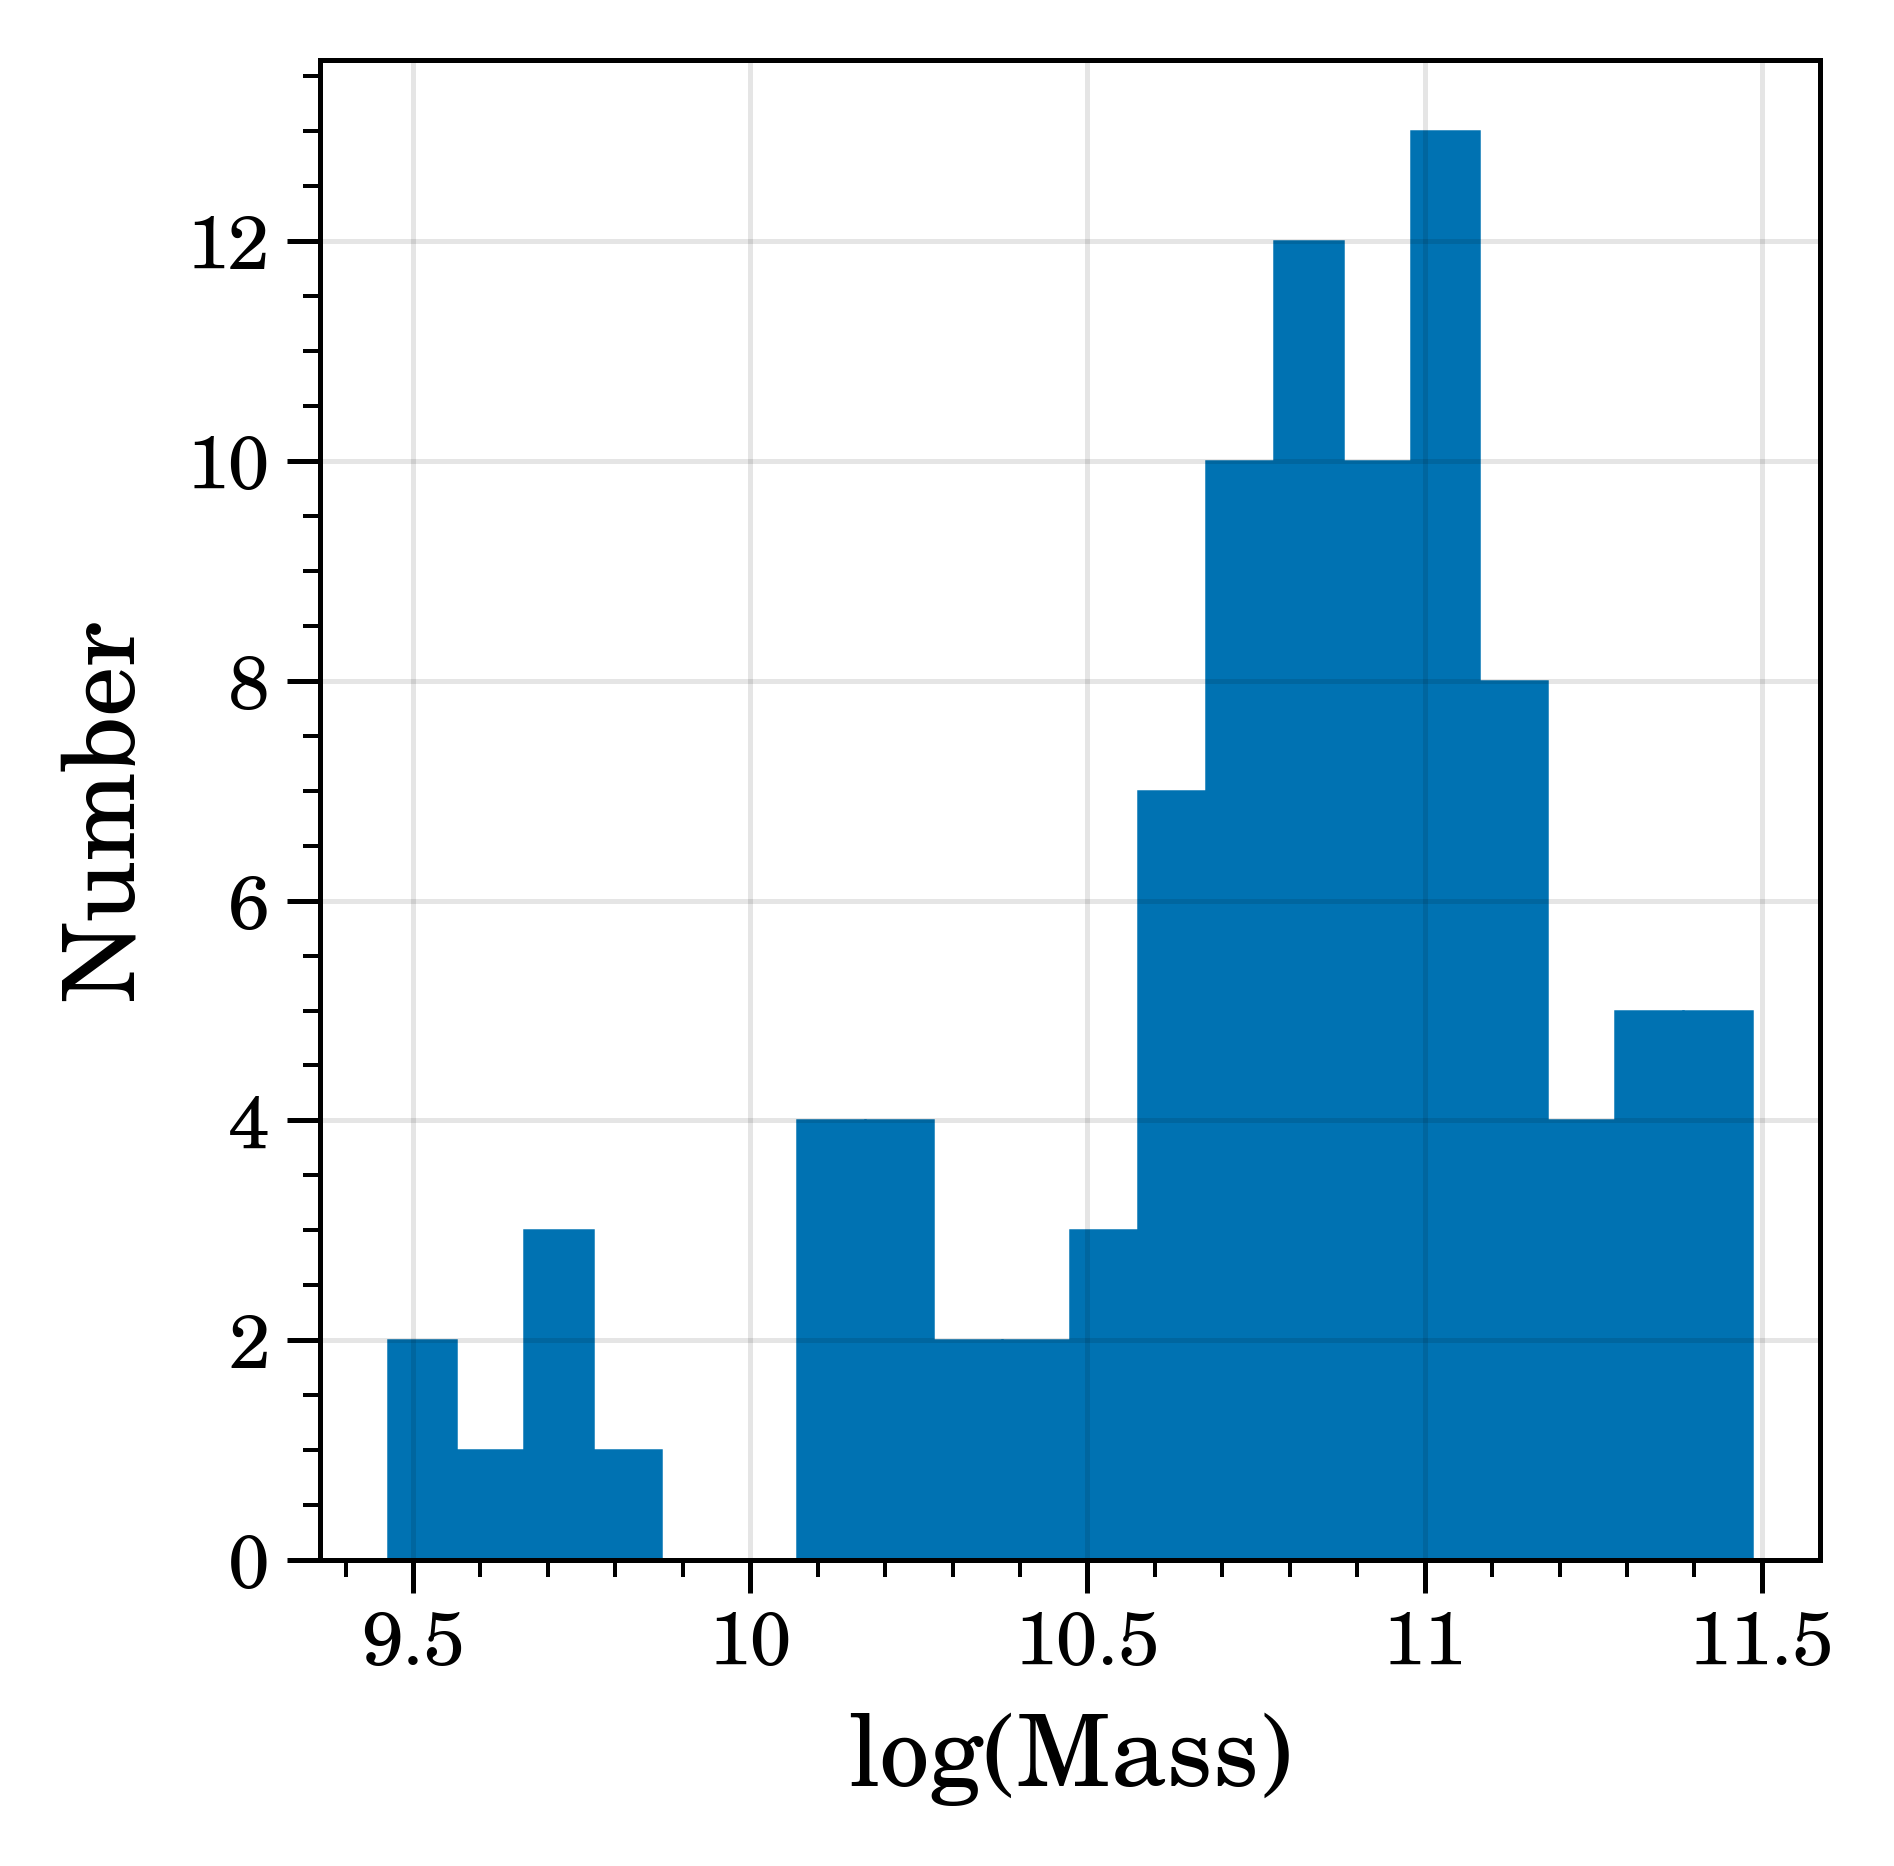

In [174]:
fig, ax = pplt.subplots()
ax.hist(M, bins=20)
ax.format(xlabel='log(Mass)', ylabel='Number')
pplt.show()

In [139]:
from MyTool_2 import reju_gal
rej_0 = reju_gal()[0]
rej_1 = np.load('/Users/txl/Desktop/MaNGA/Final_REJ/from_1st_folder.npy')
rej_2 = np.load('/Users/txl/Desktop/MaNGA/Final_REJ/from_2nd_folder.npy')
rej_3 = np.load('/Users/txl/Desktop/MaNGA/Final_REJ/from_QSO_folder.npy')

There are 32 local rejuvenating galaxies. 32


In [149]:
rej_all = list(set(rej_0) | set(rej_1) | set(rej_2) | set(rej_3))
rej_all.remove('12068-6104')
print(len(rej_all), rej_all)

48 ['9492-12704', '11941-12704', '9195-9101', '7959-12705', '8244-6101', '12074-9101', '8249-12704', '9195-6104', '8241-12704', '8444-12703', '9045-12703', '8567-9102', '9884-12703', '8448-9101', '11749-12701', '7964-9101', '9186-6103', '11872-12704', '8447-3704', '11012-9102', '11948-12704', '8713-12701', '8995-12705', '11978-12703', '9870-3702', '8438-12702', '8978-12705', '9510-3702', '8438-9101', '8258-9101', '9879-12704', '8938-12702', '9047-12703', '8135-12701', '8093-12704', '9025-3702', '10510-12704', '9024-12705', '8588-6101', '9095-12704', '8606-12705', '8324-12702', '9484-12705', '8615-12701', '8656-6104', '9039-6102', '11748-12701', '8139-1901']


In [151]:
np.save('/Users/txl/Desktop/MaNGA/Final_REJ/rej_all.npy', rej_all)

In [3]:
rej_all = np.load('/Users/txl/Desktop/MaNGA/Final_REJ/rej_all.npy')
print(len(rej_all))

48


In [12]:
ggg = list(np.load('/Users/txl/Desktop/MaNGA/Final_REJ/rej_all.npy'))

In [16]:
np.where(ggg=='11012-9102')

/var/folders/8q/svw_20t17nz2mj7zww86s_xh0000gn/T/ipykernel_42738/917114232.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(ggg=='11012-9102')


(array([], dtype=int64),)

/Users/txl/Desktop/MaNGA/Codes/MyTool.py:183: RuntimeWarning: divide by zero encountered in divide
  err  = 1/np.sqrt(ivar)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:322: RuntimeWarning: divide by zero encountered in log10
  y, x = np.log10(o3_spa/hb_spa), np.log10(n2_spa/ha_spa)
/Users/txl/Desktop/MaNGA/Codes/MyTool.py:332: RuntimeWarning: divide by zero encountered in divide
  HaEW_err  = 1/np.sqrt(HaEW_ivar)
/var/folders/8q/svw_20t17nz2mj7zww86s_xh0000gn/T/ipykernel_98761/572427715.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labelled_array, num_feature = ndimage.measurements.label(~hd.mask)


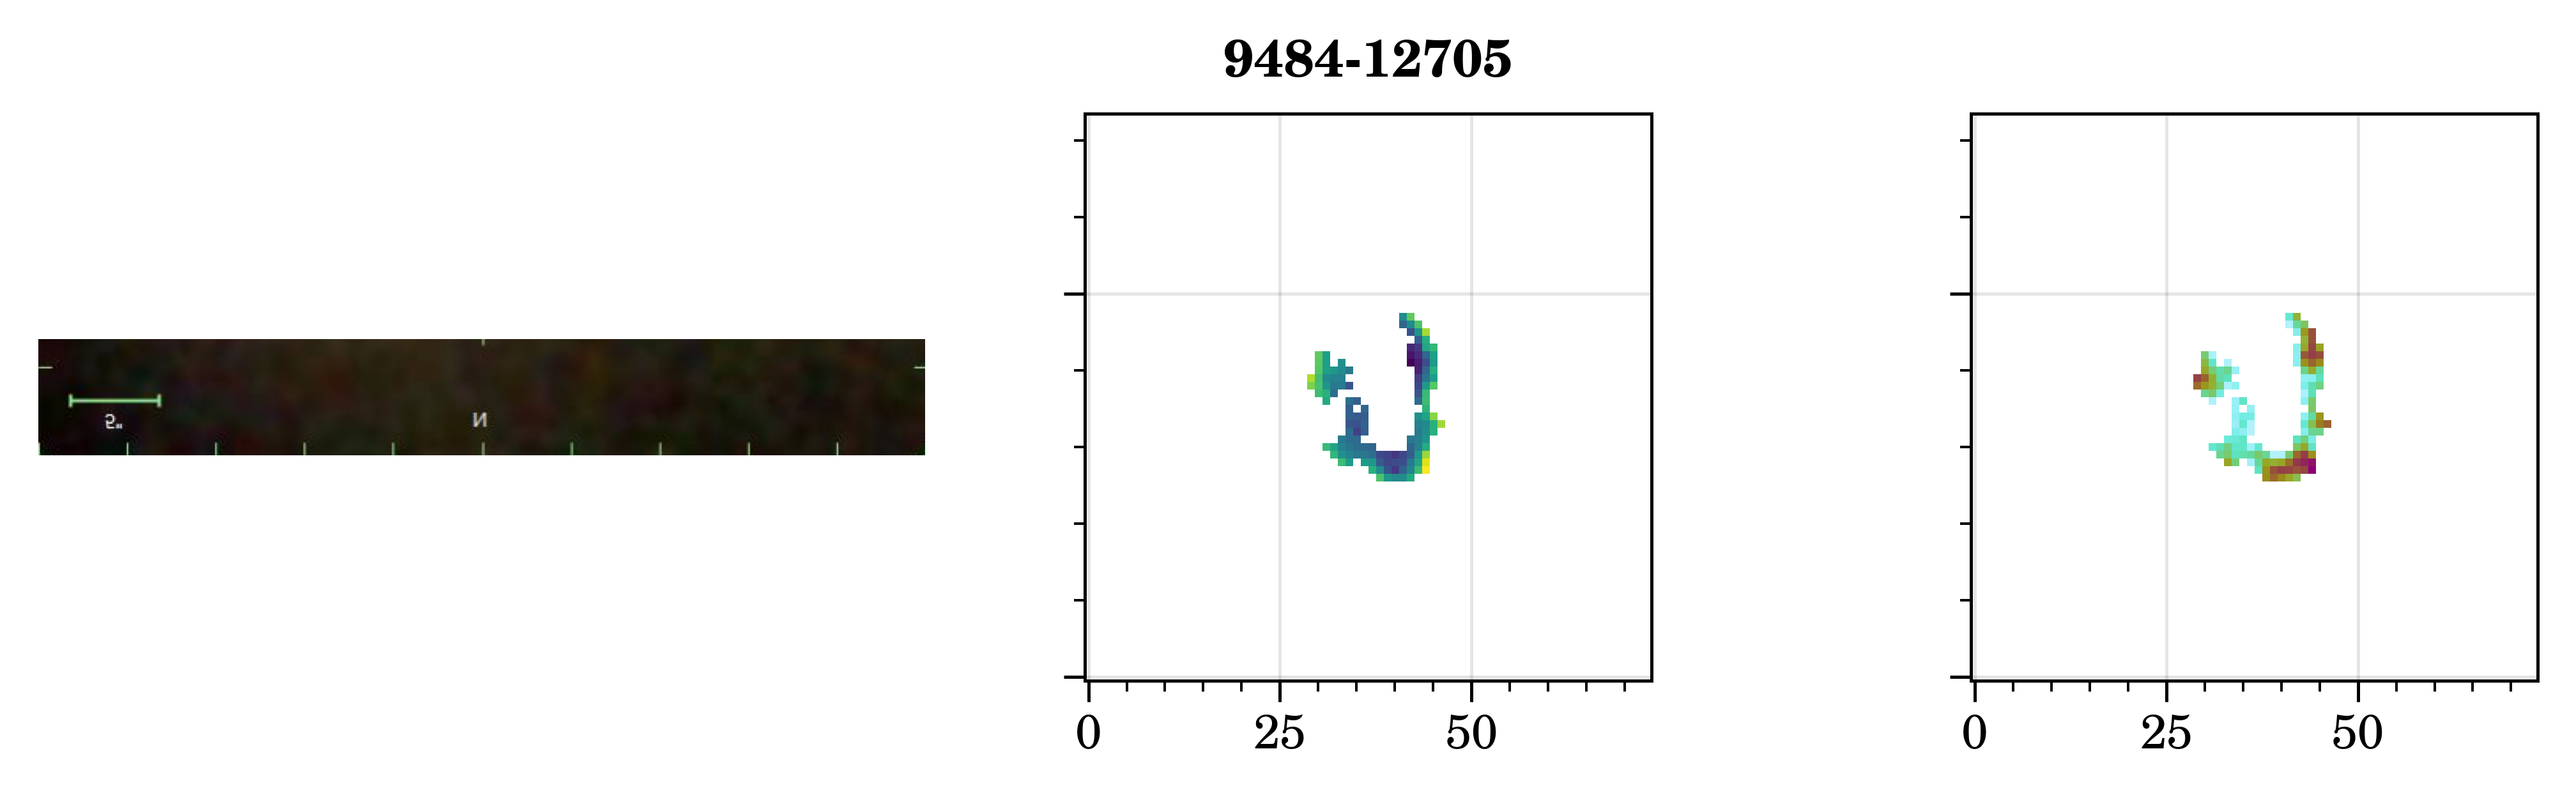

In [15]:
gal_2nd = ['9484-12705']
#from PIL import Image
import matplotlib.pyplot as plt
for gal in gal_2nd:
    maps = Maps(gal)

    # Needed mask
    mask_sf  = maps.BPT_sf_mask()[2] | maps.HaEW(lim=6)[1]  # Both SNR > 3
    hd, dn, mask_rej = maps.rejuvenated() # Rejuvenating mask, more than 10 connected spaxels will be selected
    hd, dn = np.ma.array(hd, mask=mask_rej | mask_sf, fill_value=np.nan), np.ma.array(dn, mask=mask_rej|mask_sf, fill_value=np.nan)

    labelled_array, num_feature = ndimage.measurements.label(~hd.mask)
    unique, counts = np.unique(labelled_array, return_counts = True)

    # Delete the non-target region spaxels
    counts, unique = np.delete(counts, 0), np.delete(unique, 0) # The empty in the maps
    #print(counts, unique)

    # Mask for region selection
    want_id = np.where(counts > 10)[0]
    mask_num  = ~np.isin(labelled_array, unique[want_id])
    hd, dn = np.ma.array(hd, mask=mask_num, fill_value=np.nan), np.ma.array(dn, mask=mask_num, fill_value=np.nan)
    
    # Plot
    fig, ax = pplt.subplots(ncols=3, figsize=(7,2))
    
    img = plt.imread('/Volumes/KINGSTON/MaNGA/Optical_Images/%s.png' %gal)
    ax[0].imshow(img, origin='lower')
    ax[0].axis('off')
    ax[0].set_aspect('equal')

    ax[1].imshow(dn, cmap='viridis', origin='lower')
    ax[2].imshow(hd, cmap='hawaii', origin='lower')

    fig.format(suptitle='%s' %gal)
    pplt.show()
    '''
    if np.sum(len(want_id)) == 0:
        #print('%s has no any rejuvenating region!' %gal)
        not_reju.append(gal)
    else:
        print('==== %s has %d regions! ====' %(gal, len(want_id)))
        reju_pre.append(gal)
    '''

In [ ]:
# Show optical image, Hd, and Dn
